## Kaggle: Прогноз цен на рынке недвижимости Москвы, используя машинное обучение



### Кратко код

In [ ]:
import pandas as pd
import numpy as np
import helper as h

import eli5

import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error

In [ ]:
df_train = pd.read_hdf("../input/train_data.h5")
df_train['price'] = df_train['price'].map(h.parse_price)

df_test = pd.read_hdf("../input/test_data.h5")

df = pd.concat([df_train, df_test])
print(df.shape, df.shape)

In [ ]:
params = df["params"].apply(pd.Series)
params = params.fillna(-1)

if "Охрана:" not in df:
    df = pd.concat([df, params], axis=1)
    
    obj_feats = params.select_dtypes(object).columns

    for feat in obj_feats:
        df["{}_cat".format(feat)] = df[feat].factorize()[0]

cat_feats = [x for x in df.columns if "_cat" in x]
cat_feats

In [ ]:
def parse_area(val):
    if isinstance(val, int): return val
    if isinstance(val, float): return val
    
    return float(val.split("м")[0].replace(" ", ""))

df["area"] = df["Общая площадь:"].map(h.parse_area)
df["kitchen_area"] = df["Площадь кухни:"].map(parse_area)

In [ ]:
def check_model(df, feats, model, cv=5, scoring="neg_mean_absolute_error"):
    df_train = df[ ~df["price"].isnull() ].copy()
    df_test = df[ df["price"].isnull() ].copy()

    X_train = df_train[feats]
    y_train = df_train["price"]
    
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
    return np.mean(scores), np.std(scores)


def check_log_model(df, feats, model, cv=5, scoring="neg_mean_absolute_error"):
    df_train = df[ ~df["price"].isnull() ].copy()

    X = df_train[feats]
    y = df_train["price"]
    y_log = np.log(y)
    
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_log_train, y_test = y_log.iloc[train_idx], y.iloc[test_idx]

        model = xgb.XGBRegressor(max_depth=7, n_estimators=500,learning_rate=0.2, random_state=0)
        model.fit(X_train, y_log_train)
        y_log_pred = model.predict(X_test)
        y_pred = np.exp(y_log_pred)

        score = mean_absolute_error(y_test, y_pred)
        scores.append(score)

    return np.mean(scores), np.std(scores)

In [ ]:
geo_block = (
df["geo_block"]
    .map(lambda x: x[:int(len(x)/2) ])
    .map(lambda x: {"geo_block_{}".format(idx):val for idx,val in enumerate(x) })
    .apply(pd.Series)
)

geo_block

In [ ]:
geo_cat_feats = [x for x in df.columns if "geo_block" in x and "_cat" in x]
geo_cat_feats

In [ ]:
feats = ["area", "kitchen_area"] + geo_cat_feats + cat_feats

check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

In [ ]:
breadcrumbs = (
    df["breadcrumbs"]
        .map(lambda x: {"breadcrumbs_{}".format(idx):val for idx,val in enumerate(x) })
        .apply(pd.Series)
)

breadcrumbs

In [ ]:
breadcrumbs_cat_feats = [x for x in df.columns if "breadcrumbs" in x and "_cat" in x]
breadcrumbs_cat_feats

In [ ]:
#Standardize floor notation to integer values
df["Level"]=df["Этаж:"].map(lambda x: int(str(x).split("/")[0].replace(" ", "")))

#Get City and other adress details into two separate columns from "Адрес:"
df["City"]=df["Адрес:"].str.split(',').str[0].factorize()[0]
df["Adress"]=df["Адрес:"].str.split(',').str[1].factorize()[0]
df["Adress"]=df["Adress"].fillna(-1)

# create a list of our conditions parking type
conditions = [
    (df["Парковка:"].str.contains("подземная", case=False) ==True),
    (df["Парковка:"].str.contains("наземная", case=False) ==True),
    (df["Парковка:"].str.contains("крытая", case=False) ==True),
    (df["Парковка:"].str.contains("открытая", case=False) ==True),
    (df["Парковка:"]==-1)
    ]

# create a list of the values we want to assign for each condition
values = ["Подземная", "Наземная", "Крытая", "Открытая",-1]

# create a new column and use np.select to assign values to it using our lists as arguments
df["Parking"] = np.select(conditions, values)
df["Parking"] = df["Parking"].factorize()[0]

# create a list of our conditions for building type
conditions = [
    (df["Тип здания:"].str.contains("Монолитно-кирпичн", case=False) ==True),
    (df["Тип здания:"].str.contains("Монолитно-панел", case=False) ==True),
    (df["Тип здания:"].str.contains("монолит", case=False) ==True),
    (df["Тип здания:"].str.contains("Панельно-кирпич", case=False) ==True),
    (df["Тип здания:"].str.contains("Кирпич", case=False) ==True),
    (df["Тип здания:"].str.contains("панел", case=False) ==True),
    (df["Тип здания:"].str.contains("блочн", case=False) ==True),
    (df["Тип здания:"].str.contains("деревян", case=False) ==True),
    (df["Тип здания:"].str.contains("сталинск", case=False) ==True),
    (df["Тип здания:"]==-1)
    ]

# create a list of the values we want to assign for each condition
values = ["м\к", "м\п", "монолит", "п\к","кирпич","панель","блок","дерево","сталинка",-1]

# create a new column and use np.select to assign values to it using our lists as arguments
df["Building_type"] = np.select(conditions, values)
df["Building_type"]=df["Building_type"].factorize()[0]


#Standardize Security data
df["Security1"] = np.where(df["Охрана:"].str.contains("-1"),int("-1"),int("0"))
df["Security2"]=np.where(df["Охрана:"].str.contains("закрытая|предусмотрена|охран", case=False,na=False, regex=True),int("1"),int("0"))
df["Security5"]=np.where(df["Охрана:"].str.contains("видео", case=False,na=False, regex=True),int("1"),int("0"))
df["Security7"]=np.where(df["Охрана:"].str.contains("огорожен", case=False,na=False, regex=True),int("1"),int("0"))
df["Security8"]=np.where(df["Охрана:"].str.contains("консьерж", case=False,na=False, regex=True),int("1"),int("0"))
df["Security9"]=np.where(df["Охрана:"].str.contains("доступ", case=False,na=False, regex=True),int("1"),int("0"))

Sum_col=df["Security1"]+df["Security2"]+df["Security5"]+df["Security7"]+df["Security8"]+df["Security9"]
df["Security"]= Sum_col


max_Level=df["Этажность:"].str.split("до",expand=True)[1]
df["Этажность:"]=max_Level.fillna(-1)
df["Этажность:"]=df["Этажность:"].replace(" ", "")
df["Количество этажей:"]=np.where(df["Количество этажей:"] == -1, df["Этажность:"], df["Количество этажей:"])
df["Количество этажей:"]=df["Количество этажей:"].map(lambda x: int(x))
df["Количество этажей:"]=np.where(df["Количество этажей:"] == -1, df["Наибольшее количество этажей:"], df["Количество этажей:"])
df["Количество этажей:"]=df["Количество этажей:"].map(lambda x: int(x))

df["Тип объекта:"]=df["Тип объекта:"].replace("квартиры","квартира")
df["Тип объекта:_cat"]=df["Тип объекта:"].factorize()[0]

df["Жилая комната:_cat"]=df["Жилая комната:"].map(parse_area)
df["Высота потолков:"]=df["Высота потолков:"].map(parse_area)

#log area data
area=df["area"]
df["log_area"]=np.log(area)
df["log_area"]=df["log_area"].fillna(-1)

kitchen=df["kitchen_area"]
df["log_kitchen"]=np.log(area)
df["log_kitchen"]=df["log_kitchen"].fillna(-1)

room = df["Жилая комната:"].map(parse_area)
df["log_room"] = np.log(room)
df["log_room"]=df["log_room"].fillna(-1)


#Standardize Series data
df["Серия:"]=df["Серия:"].replace(["Индивидуальный проект","Индивидуальный","Инд","индивидуальный проект",
                                  "индивидуальный","инд.", "индивид.", 
                                    "Индивидуальный проект с подземным паркингом", "серии нет, тип проекта - индивидуальный",
                                  "Индивид.", "индивидуал", "Индивидуальная", "Индив.", "Инд.","индив."],"индивид")
df["Серия:"]=df["Серия:"].replace(".","")
df["Серия:"]=df["Серия:"].replace(" ","")

df["Серия:_cat"]=df["Серия:"].factorize()[0]



In [ ]:
feats = ["area", "kitchen_area"] + geo_cat_feats + cat_feats + breadcrumbs_cat_feats

In [ ]:
feats1 = ["Level", "City", "Adress", "Parking", "Building_type", "Security", "Количество этажей:", 
         "Высота потолков:", "log_area", "log_kitchen", "log_room"]+feats

In [ ]:
df["kitchen_ratio"]=np.where((df["kitchen_area"]!=-1) & (df["area"]!=-1),df["kitchen_area"]/df["area"],-1)
df["kitchen_ratio"]


feats2 = ["kitchen_ratio"]+feats1


In [ ]:
df["offers_count"]=(
    df.groupby("Застройщик:")
    ["Застройщик:"]
    .transform("count")
)

df["offers_count"].value_counts()
feats3 = ["offers_count"]+feats2

In [ ]:
df["area_per_Class"]=(
    df.groupby("Класс жилья:")
    ["area"]
    .transform("mean")
)

df["area_per_Class"].value_counts()

feats4 = ["area_per_Class"]+feats3

In [ ]:
df["area_per_company"]=(
    df.groupby("Застройщик:")
    ["area"]
    .transform("median")
)

df["area_per_company"].value_counts()

feats5 = ["area_per_company"]+feats4

In [ ]:
black_list=["area","kitchen_area","Площадь кухни:_cat","Наибольшее количество этажей:_cat"]
feats5_bl = [x for x in feats5 if x not in black_list]
check_log_model(df, feats5_bl, xgb.XGBRegressor(max_depth=7, n_estimators=500, learning_rate=0.2, random_state=0))

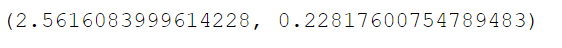

In [ ]:
feats = feats5_bl

df_train = df[ ~df["price"].isnull() ].copy()
df_test = df[ df["price"].isnull() ].copy()

X_train = df_train[feats]
y_train = df_train["price"]
y_log_train = np.log(y_train)

X_test = df_test[feats]

model = xgb.XGBRegressor(max_depth=7, n_estimators=500, learning_rate=0.2, random_state=0)
model.fit(X_train, y_log_train)
y_log_pred = model.predict(X_test)
y_pred = np.exp(y_log_pred)


df_test["price"] = y_pred
df_test[ ["id", "price"] ].to_csv("../output/xgb_location_log_area3.csv", index=False)

### Подробная логика и ход мыслей

### Загрузили библиотеки

In [ ]:
import pandas as pd
import numpy as np
import helper as h

import eli5

import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error

### Загрузили данные
Объеденяем тренировочные и тестовые данные, чтобы все приписываемые индексы и преобразования были общими для обоих наборов данных. И сразу с ними ознакомились

In [ ]:
df_train = pd.read_hdf("../input/train_data.h5")
df_train['price'] = df_train['price'].map(h.parse_price)

df_test = pd.read_hdf("../input/test_data.h5")

print(df_train.shape, df_test.shape)
df = pd.concat([df_train, df_test])

df.sample(10)

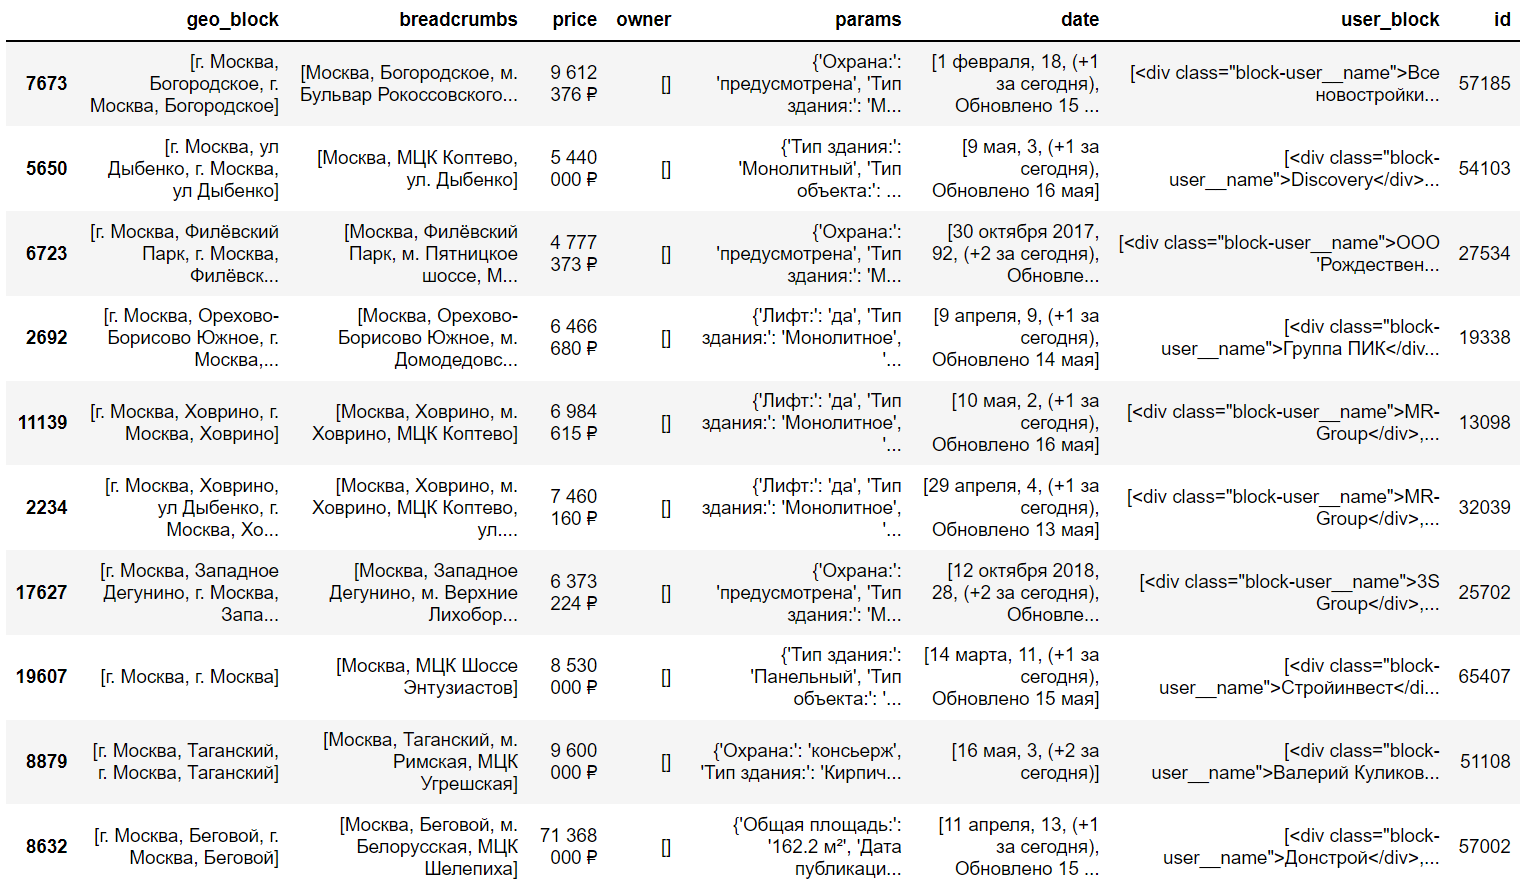

На данном этапе следую советам в стартерах 1-2 и разбиваю `Params` на категории содержащиеся внутри, отсутствующие значения заполняю -1. Здесь, стоит отметить, что по ходу работы замена на -1 в нескольких каткгориях усложнила жизнь и для них я предпочла бы замену на 0 (0 тоже отсутствовал в изначальном наборе данных)

In [ ]:
params = df["params"].apply(pd.Series)
params = params.fillna(-1)

if "Охрана:" not in df:
    df = pd.concat([df, params], axis=1)

Так же захотелось сразу вытянуть город из `geo_block`, поскольку это было еще до финальных стартеров идею как это сделать нашла в шпаргалке по pandas. `Apply` с наскока при отсутствии опыта применить не получилось

In [ ]:
df["City"] =df["geo_block"].map(lambda x: x[0])

df.sample(5)

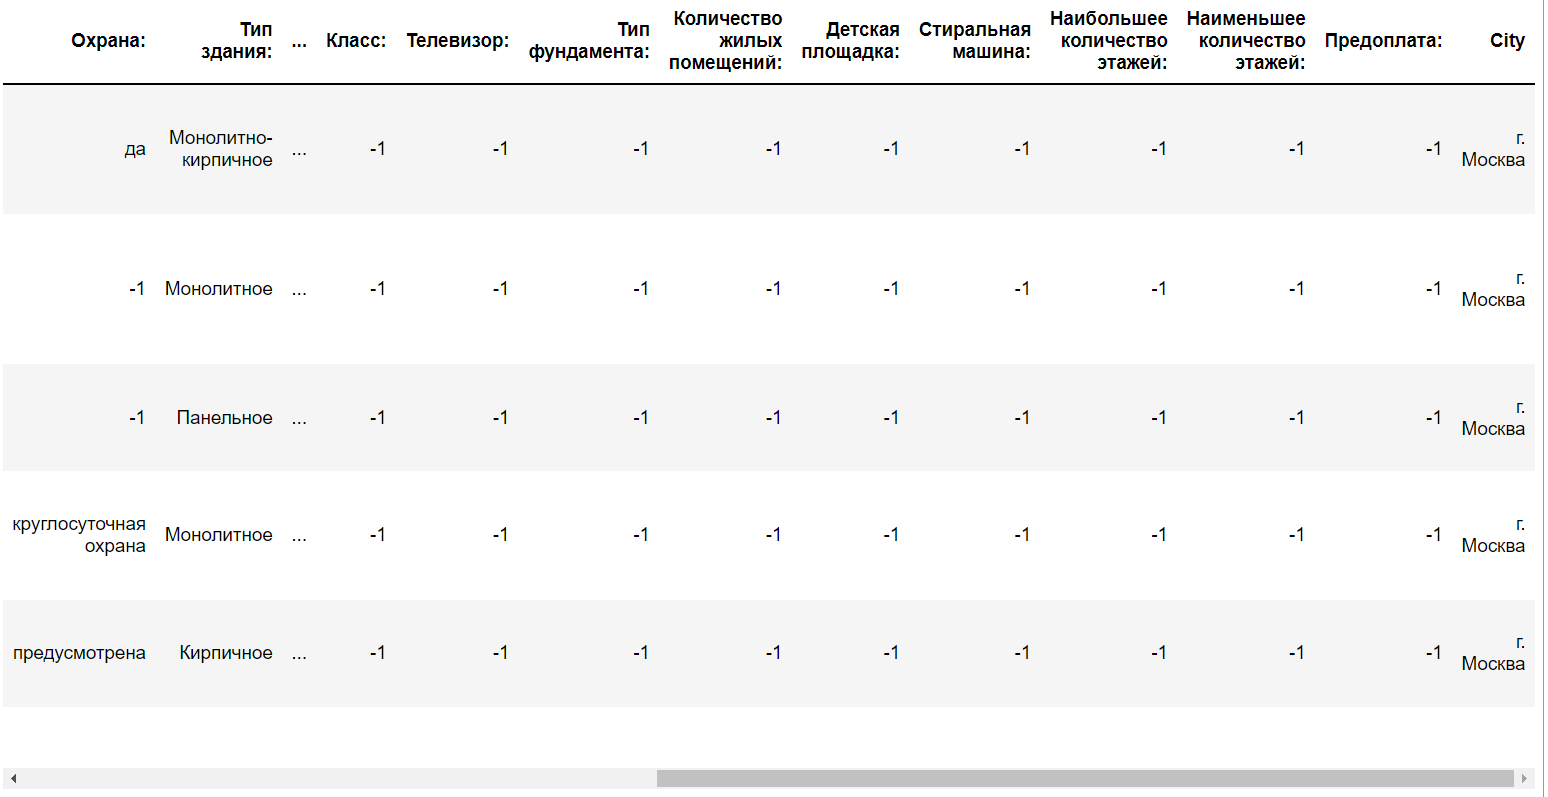

После посмотрела количество уникальных значений для каждой из категорий. И изучала содержимое категорий с наибольшим числом уникальных значений, хотя за два дня мастер-класса проверила в итоге все.

In [ ]:
feats_nunique = {feat:params[feat].nunique() for feat in params.columns}
{k: v for k, v in sorted(feats_nunique.items(), key=lambda item: item[1])}

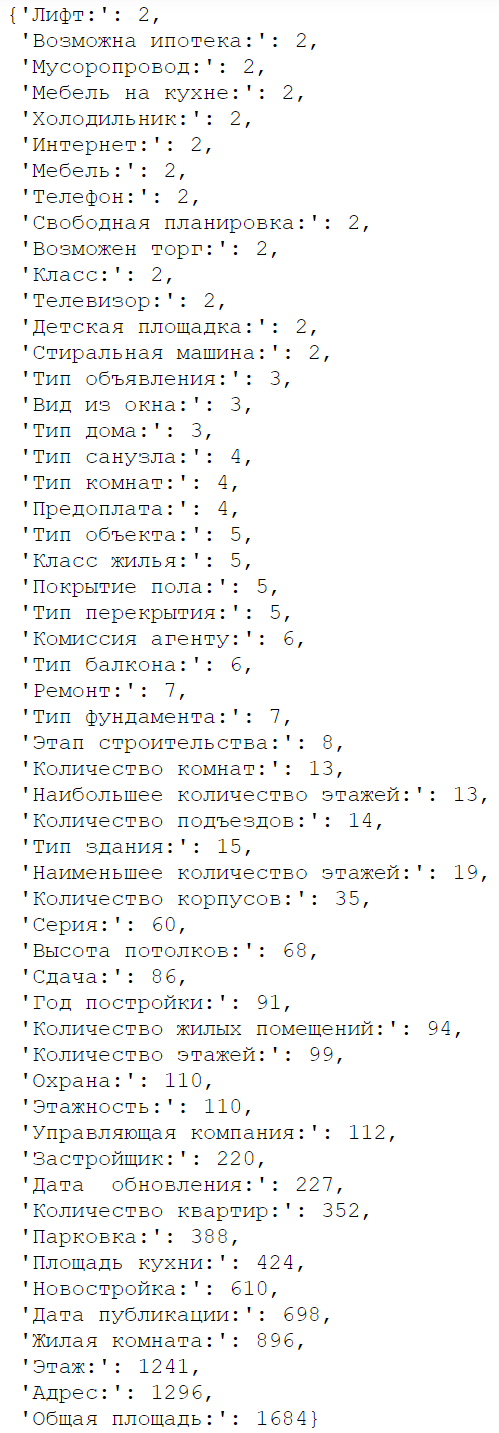

Пропускаю все через `factorize`, опять же как в стартерах, с мыслью, что делается это быстро, а исключить лишнее всегда успею

In [ ]:
    obj_feats = params.select_dtypes(object).columns

    for feat in obj_feats:
        df["{}_cat".format(feat)] = df[feat].factorize()[0]

cat_feats = [x for x in df.columns if "_cat" in x]
cat_feats

Разделила тренировочную и тестовую части и приготовила первую модель, чтобы было с чем сравнивать потом показатели 

In [ ]:
df_train = df[ ~df["price"].isnull() ].copy()
df_test = df[ df["price"].isnull() ].copy()

df_train.shape, df_test.shape

In [ ]:
X_train = df_train[cat_feats]
y_train = df_train["price"]

X_test = df_test[cat_feats]

In [ ]:
model = DecisionTreeRegressor(max_depth=5)
scores = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_absolute_error")
np.mean(scores), np.std(scores)

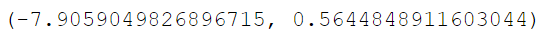

Валидация модели показала большое отклонение, но уже появились цифры с чем сравнивать все последующие манипуляции с данными и процесс feature engineering

В процессе довольно часто пользовалась `eli5`, из расчета, если какая-то категория из наиболее значимых для модели логически была странной или же наоборот, то что логически точно должно влиять на цену оказывалось в конце, то такие категории я просматривала еще раз через `value_counts`

In [ ]:
eli5.show_weights(model, feature_names=cat_feats)

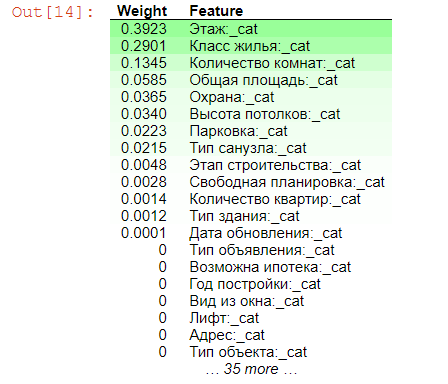

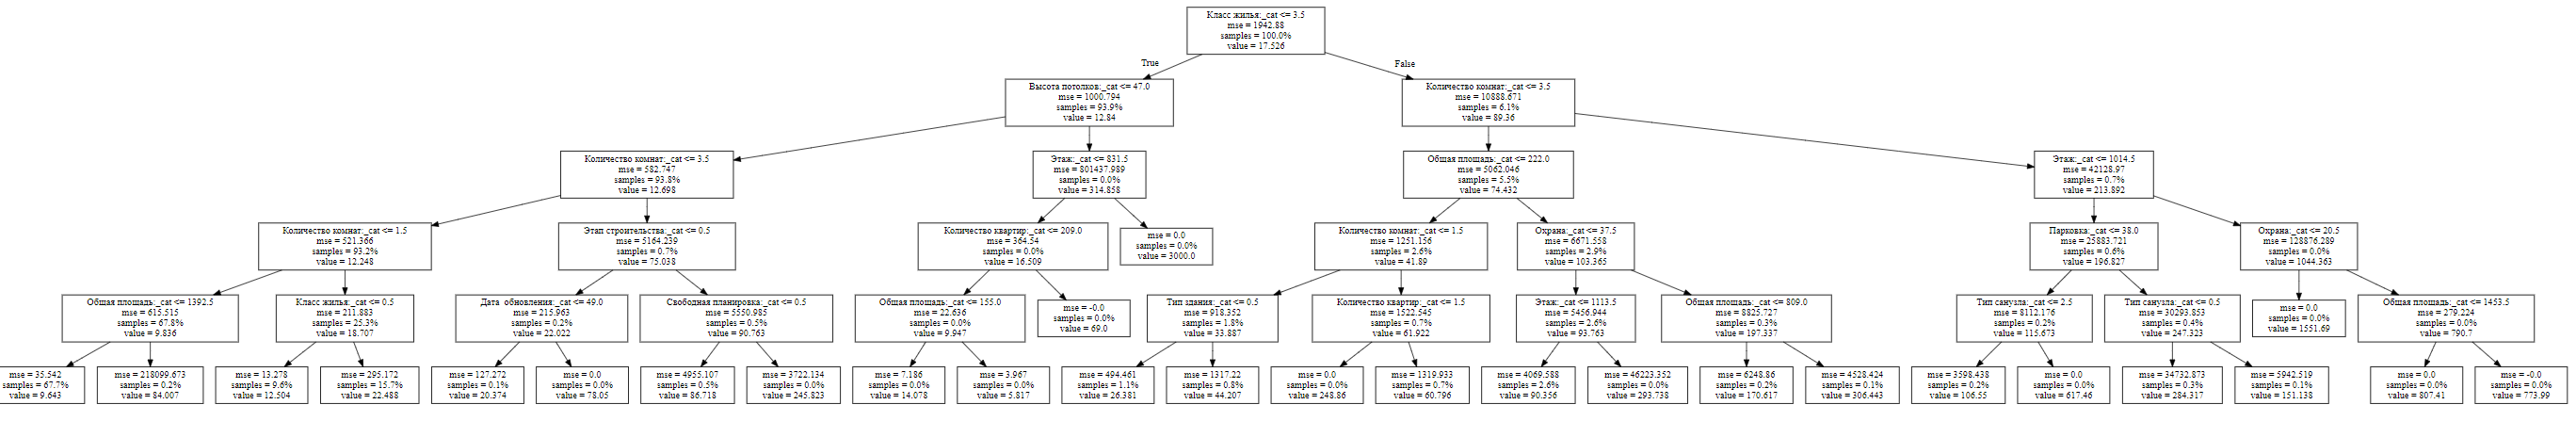

Дальше идет собственно анализ данных и работа с ними. Часть кода сразу удалялалсь если ничего интересного не находила. При работе с последующими стартерами поняла, что код стоило комментировать и оставлять, так проще было бы контролировать, что проверялось и какие были результаты

In [ ]:
df["Тип балкона:"].value_counts(normalize=True)

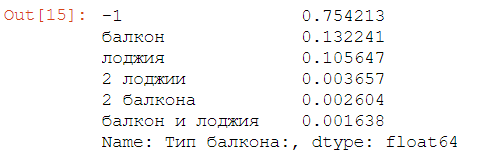

In [ ]:
pd.pivot_table(df, index=["Тип балкона:"], values=["price"], aggfunc=["mean", "median", "min", "max", len])

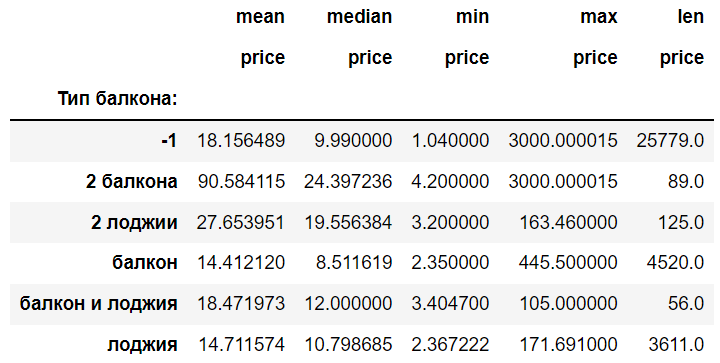

- в большинстве случаев (более 75%) отсутствует информация о "типе балкона" (там где значение -1)
- присутствие двух балконов или двух лоджий значительно увеличивают среднюю цену и медиану
- Квартиры с двумя балконами стоят дороже квартир с двумя лоджиями
- Квартира с лоджией вероятнее будет дороже квартиры с балконом (по медиане)
- Квартир с балконом больше чем с лоджией

In [ ]:
df["Класс жилья:"].value_counts(normalize=True)

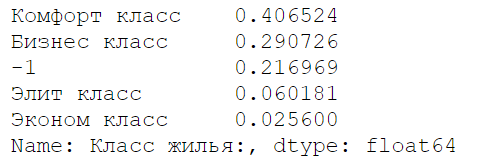

In [ ]:
pd.pivot_table(df, index=["Класс жилья:"], values=["price"], aggfunc=["mean", "median", "min", "max", len])

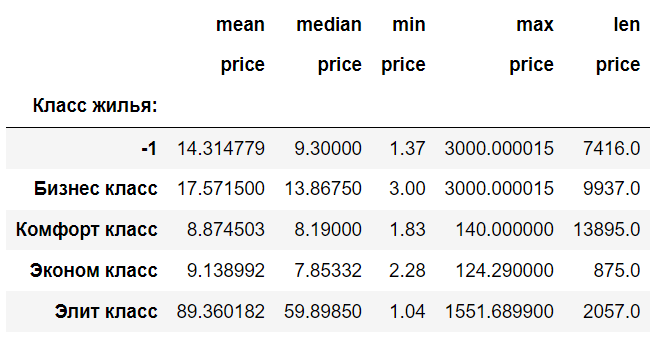

- в 21% данных не указан класс жилья
- Большинство квартир в данных относятся или к "комфорт классу" (40%) или к "бизнес классу" (29%)
- Всего 2.5% квартир относятся к "эконом классу"
- Минимальная цена квартиры в "элит класса" меньше минимальной цены квартиры в "эконом классе" и "комфорт классе" (возможно есть большая разница в площади квартир с минимальными ценами или городе)
- В среднем квартиры "элит класса" в 10 раз дороже "комфорт" и " эконом класса"
- Самые дорогие квартиры относятся к "бизнес классу" и к некатегоризированной. ??? Максимальная цена идентична, возможно был значение в некатегоризированой оказалось не правильно заполнено и потом сдублировано, т.е. например адресс, квартира, параметры совпадают, но объявлений выставлено было два из-за технического сбоя или просто не правильного заполнения. Отсюда вопрос к качеству данных, по-хорошему нужно как-то проверить на очевидные дубликаты и вычистить их. В работе не делала т.к. не хотелось перебирать данные руками

In [ ]:
df["Этаж:"].value_counts(normalize=True)

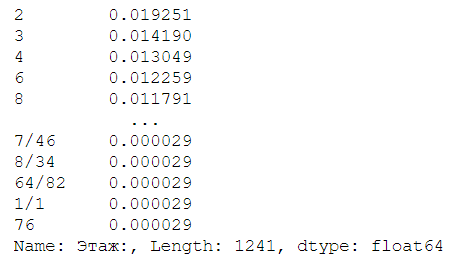

In [ ]:
pd.pivot_table(df, index=["Этаж:"], values=["price"], aggfunc=["mean", "median", "min", "max", len])

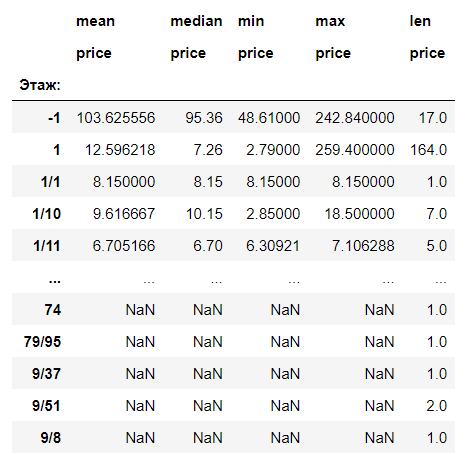

- Много разных отображений одного этажа: 1, 1\1, 1\10, 1\11 и т.д. 
- Наибольшее количество этажей возможно следует объединить с Этажностью. Как по мне обе категории показывают количество этажей в здании где находится жилью, тогда если значение совпадает с значение после слеша в столбце Этаж, его можно удалить. Если значения нет, а есть написанные этажи через слеш, то опять же взять число после слеша, оставив в столбце Этаж только одно число в числовом же формате.

В дальнейшем будет приведено к единому виду

In [ ]:
df["Охрана:"].value_counts(normalize=True)

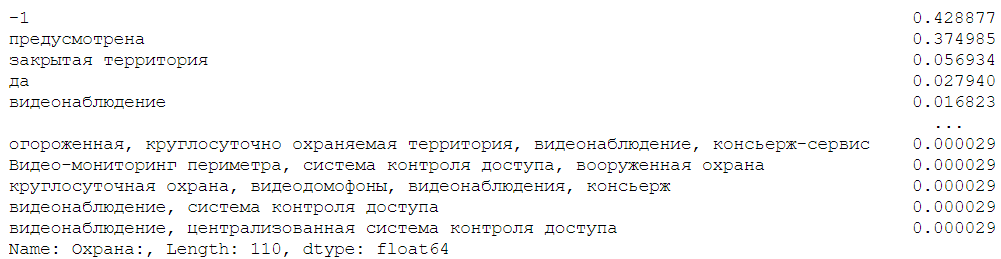

In [ ]:
pd.pivot_table(df, index=["Охрана:"], values=["price"], aggfunc=["mean", "median", "min", "max", len])


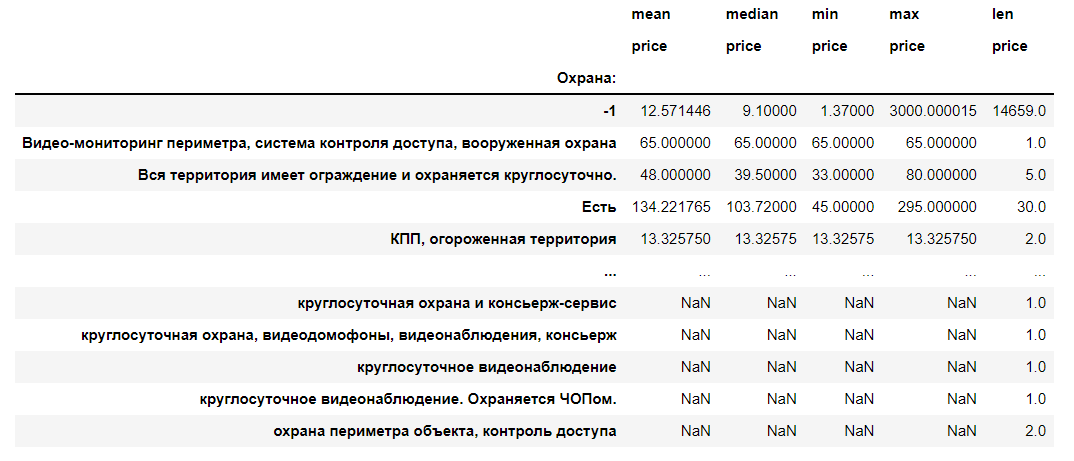

- 43% данных не содержат информации по охране
- Всего Охрана делится на 110 возможных значений, что для анализа нецелесообразно. Возможно имеет смысл заменить на меньшее число (Есть\Нет или Охрана\Видеонаблюдение\Другое\Отсутствует
- 39% квартир указывают, что охрана предусмотрена + остальные возможные категории, каждая из которых составляет <1%

В дальнейшем будет проранжирована

In [ ]:
df["Общая площадь:"].value_counts(normalize=True)

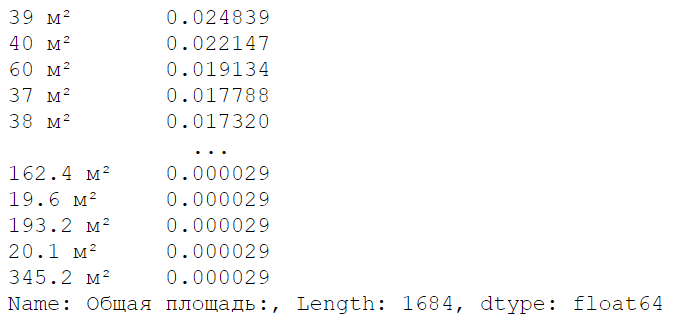

In [ ]:
pd.pivot_table(df, index=["Общая площадь:"], values=["price"], aggfunc=["mean", "median", "min", "max", len])

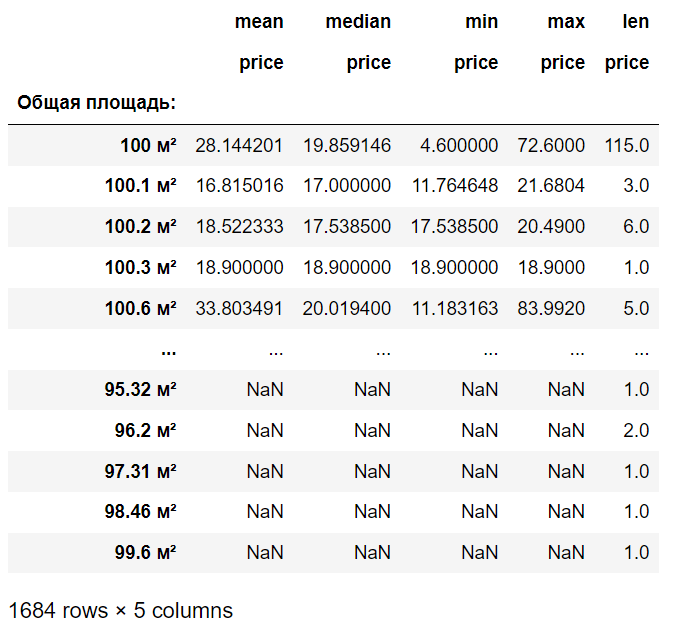

In [ ]:
Size = df["Общая площадь:"].map(lambda x: float(x.split("м²")[0].replace(" ", "")))
pd.qcut(Size, 10)
pd.qcut(Size, 10).value_counts(normalize=True)

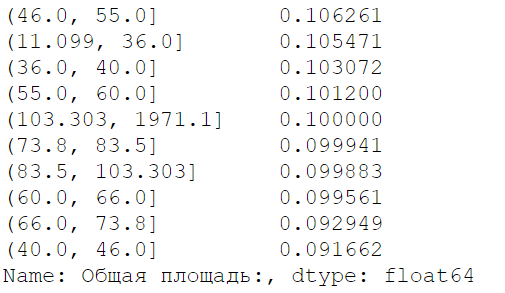

In [ ]:
Size = df["Общая площадь:"].map(lambda x: float(x.split("м²")[0].replace(" ", "")))
pd.qcut(Size, 10)
pd.pivot_table(df, index=pd.qcut(Size, 10), values=["price"], aggfunc=["mean", "median", "min", "max", len])

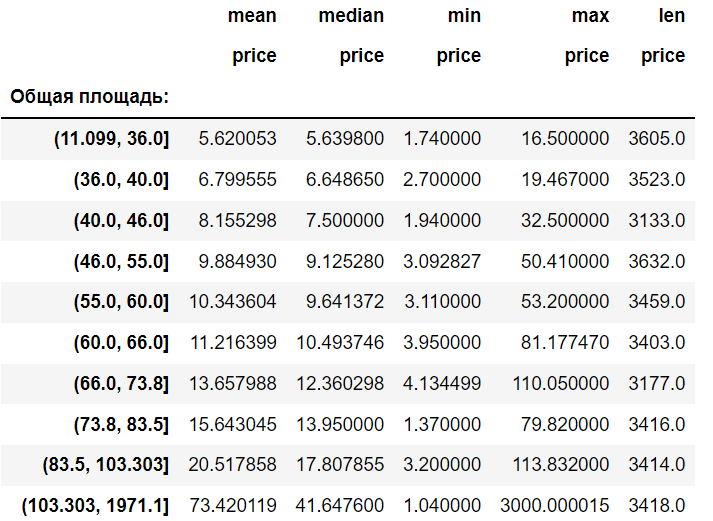

И так далее для типа объявлений, количества комнат, города, площадь, площади кухни, жилой комнаты и прочих показателей

Добавила функцию `check_model` согласно стартерам и на более поздних этапах заменила на `check_log_model` так как показало лучщие результаты

In [ ]:
def check_model(df, feats, model, cv=5, scoring="neg_mean_absolute_error"):
    df_train = df[ ~df["price"].isnull() ].copy()
    df_test = df[ df["price"].isnull() ].copy()

    X_train = df_train[feats]
    y_train = df_train["price"]
    
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
    return np.mean(scores), np.std(scores)


def check_log_model(df, feats, model, cv=5, scoring="neg_mean_absolute_error"):
    df_train = df[ ~df["price"].isnull() ].copy()

    X = df_train[feats]
    y = df_train["price"]
    y_log = np.log(y)
    
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_log_train, y_test = y_log.iloc[train_idx], y.iloc[test_idx]

        model = xgb.XGBRegressor(max_depth=7, n_estimators=500,learning_rate=0.2, random_state=0)
        model.fit(X_train, y_log_train)
        y_log_pred = model.predict(X_test)
        y_pred = np.exp(y_log_pred)

        score = mean_absolute_error(y_test, y_pred)
        scores.append(score)

    return np.mean(scores), np.std(scores)

Вытянула из площадей числовые значения

In [ ]:
def parse_area(val):
    if isinstance(val, int): return val
    if isinstance(val, float): return val
    
    return float(val.split("м")[0].replace(" ", ""))

In [ ]:
df["area"] = df["Общая площадь:"].map(parse_area)
df["Kitchen"]=df["Площадь кухни:"].map(parse_area)


Модель заменила на XGBoost, проверила через eli5 как и что влияет на модель

In [ ]:
feats = ["area"] + cat_feats

check_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

In [ ]:
feats1=feats+["Kitchen"]
check_model(df, feats1, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

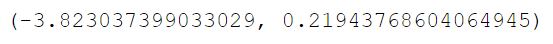

In [ ]:
eli5.show_weights(model, feature_names=feats)

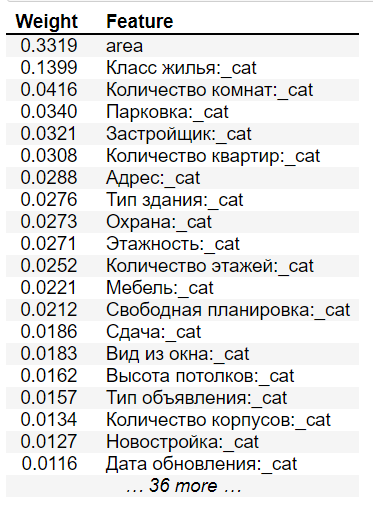

Привела этаж к одинаковой записи, количество уникальных значений сократилось с 1241 до 90, качество модели улучшилось с 3.82 до 3.71

In [ ]:
df["Level"]=df["Этаж:"].map(lambda x: int(str(x).split("/")[0].replace(" ", "")))

In [ ]:
pd.pivot_table(df, index=["Level"], values=["price"], aggfunc=["mean", "median", "min", "max", len])

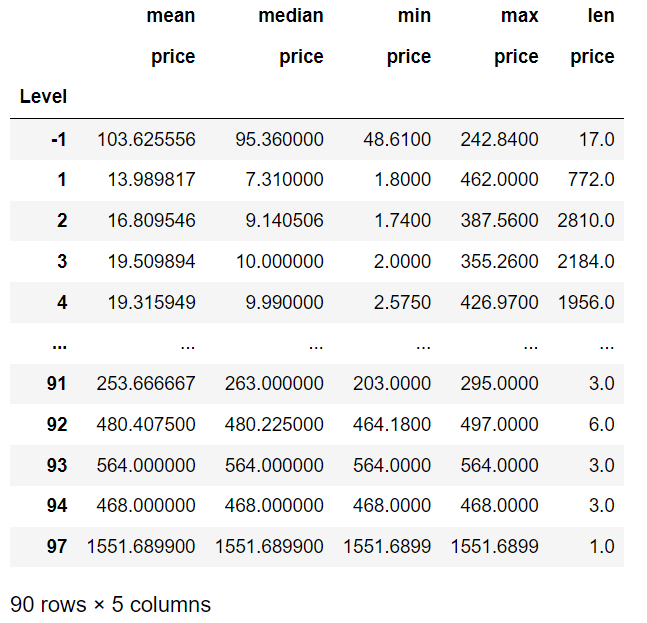

In [ ]:
check_model(df, feats2, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

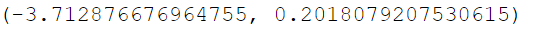

In [ ]:
feats = feats2
df_train = df[ ~df["price"].isnull() ].copy()
df_test = df[ df["price"].isnull() ].copy()

X_train = df_train[feats]
y_train = df_train["price"]

X_test = df_test[feats]

model = xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
scores = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_absolute_error")
np.mean(scores), np.std(scores)

In [ ]:
eli5.show_weights(model, feature_names=feats)

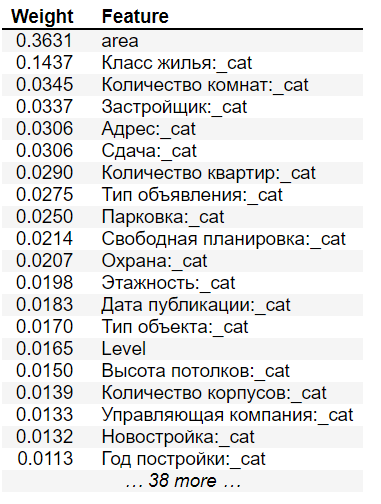

После просмотра `eli5` нашла категорию Адрес, которая объединяла город + улицу. Разделение на две разных категории ухудшило модель с 3.71 до 3.78. Но я все равно оставила деление.

In [ ]:
df["Адрес:"].map(lambda x: x.split(",")[0])

In [ ]:
df["City"]=df["Адрес:"].str.split(',').str[0].factorize()[0]
df["Adress"]=df["Адрес:"].str.split(',').str[1].factorize()[0]
df["Adress"]=df["Adress"].fillna(-1)

In [ ]:
feats3=["City"]+["Adress"]+feats2

In [ ]:
check_model(df, feats3, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

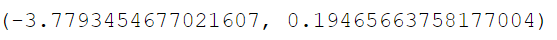

Преобразование по парковки не совсем корректно, так как исключало возможность наличия нескольких видов парковок сразу, но количество возможных категорий сократилось до 5: подземная, наземная, крытая, открытая и данных нет (-1).
Качество модели улучшилось с 3.78 до 3.76 (адрес разбитый на город и улицы остался)

In [ ]:
df["Парковка:"].sample(10)

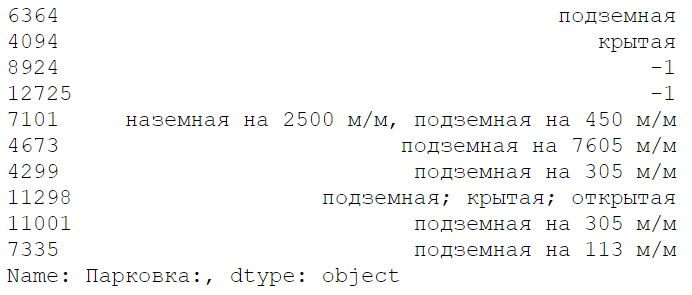

In [ ]:
# create a list of our conditions
conditions = [
    (df["Парковка:"].str.contains("подземная", case=False) ==True),
    (df["Парковка:"].str.contains("наземная", case=False) ==True),
    (df["Парковка:"].str.contains("крытая", case=False) ==True),
    (df["Парковка:"].str.contains("открытая", case=False) ==True),
    (df["Парковка:"]==-1)
    ]

# create a list of the values we want to assign for each condition
values = ["Подземная", "Наземная", "Крытая", "Открытая",-1]

# create a new column and use np.select to assign values to it using our lists as arguments
df["Parking"] = np.select(conditions, values)


In [ ]:
df["Parking"].value_counts(normalize=True)

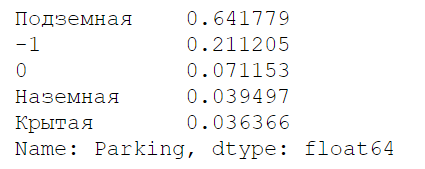

In [ ]:
df["Parking"]=df["Parking"].factorize()[0]

In [ ]:
feats4=["Parking"]+feats3
check_model(df, feats4, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

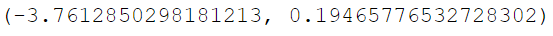

Тип здания содержит много различных написаний для одного значения. Произвела замену. Модель улучшилась с 3.76 до 3.75

In [ ]:
df["Тип здания:"].value_counts(normalize=True)

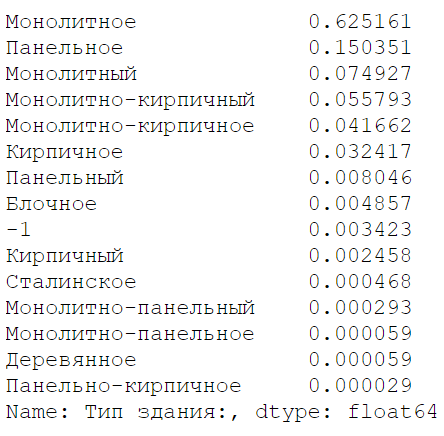

In [ ]:
# create a list of our conditions
conditions = [
    (df["Тип здания:"].str.contains("Монолитно-кирпичн", case=False) ==True),
    (df["Тип здания:"].str.contains("Монолитно-панел", case=False) ==True),
    (df["Тип здания:"].str.contains("монолит", case=False) ==True),
    (df["Тип здания:"].str.contains("Панельно-кирпич", case=False) ==True),
    (df["Тип здания:"].str.contains("Кирпич", case=False) ==True),
    (df["Тип здания:"].str.contains("панел", case=False) ==True),
    (df["Тип здания:"].str.contains("блочн", case=False) ==True),
    (df["Тип здания:"].str.contains("деревян", case=False) ==True),
    (df["Тип здания:"].str.contains("сталинск", case=False) ==True),
    (df["Тип здания:"]==-1)
    ]

# create a list of the values we want to assign for each condition
values = ["м\к", "м\п", "монолит", "п\к","кирпич","панель","блок","дерево","сталинка",-1]

# create a new column and use np.select to assign values to it using our lists as arguments
df["Building_type"] = np.select(conditions, values)


In [ ]:
df["Building_type"].value_counts(normalize=True)

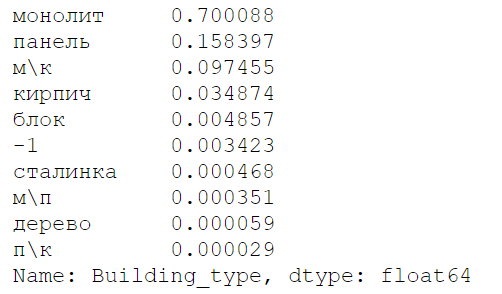

In [ ]:
df["Building_type"]=df["Building_type"].factorize()[0]
feats5=["Building_type"]+feats4
check_model(df, feats5, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

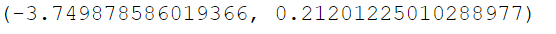

In [ ]:
eli5.show_weights(model, feature_names=feats)

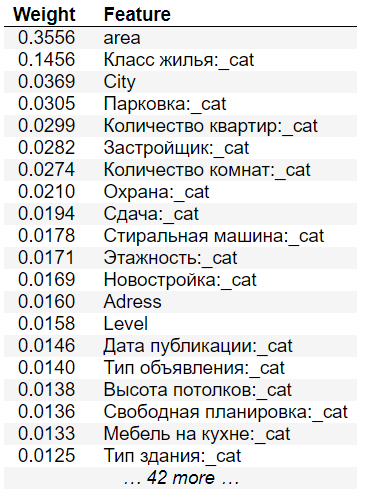

В `eli5` осознала, что в категориях теперь есть логически дублирующиеся значения (площадь_cat и  area, этаж_cat и level и т.д.) Попробовала исключить первоначальные категории. Ниже представлен успешный вариант, который улучшил качество модели, то по мере измений категорий исключение некоторых ухудшало результат и очень значительно. Логического объяснения не нашла, в реальной жизни, а не для конкурса скорее всего избавилась бы от дублирующих категорий вне зависимости от того как это повлияло бы на результат

In [ ]:
black_list=["Общая площадь:_cat","Этаж:_cat","Площадь кухни:_cat","Тип здания:_cat","Парковка:_cat","Адрес:_cat"]
feats5_bl = [x for x in feats5 if x not in black_list]
check_model(df, feats5_bl, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

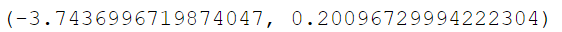

Проранжировала охрану, но результат при исключении дуплирующих категорий ухудшился до 3.77, если дубликаты оставить до 3.75, но уменьшило отклонение с 0ю2 до 0.17 и 0.18 соответственно. То есть модель более стабильна если я правильно инерпритирую результат

In [ ]:
#Standardize Security data
df["Security1"] = np.where(df["Охрана:"].str.contains("-1"),int("-1"),int("0"))
df["Security2"]=np.where(df["Охрана:"].str.contains("закрытая|предусмотрена|охран", case=False,na=False, regex=True),int("1"),int("0"))
df["Security5"]=np.where(df["Охрана:"].str.contains("видео", case=False,na=False, regex=True),int("1"),int("0"))
df["Security7"]=np.where(df["Охрана:"].str.contains("огорожен", case=False,na=False, regex=True),int("1"),int("0"))
df["Security8"]=np.where(df["Охрана:"].str.contains("консьерж", case=False,na=False, regex=True),int("1"),int("0"))
df["Security9"]=np.where(df["Охрана:"].str.contains("доступ", case=False,na=False, regex=True),int("1"),int("0"))

Sum_col=df["Security1"]+df["Security2"]+df["Security5"]+df["Security7"]+df["Security8"]+df["Security9"]
df["Security"]= Sum_col


In [ ]:
black_list=["Общая площадь:_cat","Этаж:_cat","Площадь кухни:_cat","Тип здания:_cat","Парковка:_cat","Адрес:_cat","Охрана:_cat"]
feats7_bl = ["Security"]+[x for x in feats5_bl if x not in black_list]
check_model(df, feats7_bl, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

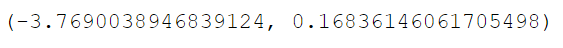

In [ ]:
feats7=["Security"]+feats5
check_model(df, feats7, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

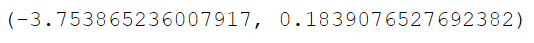

Объеденила Этажность, количество этажей и наибольшее количество этажей, модель с дублирующими категориями снова показалась успешнее score = 3.6

In [ ]:
df["Этажность:"]

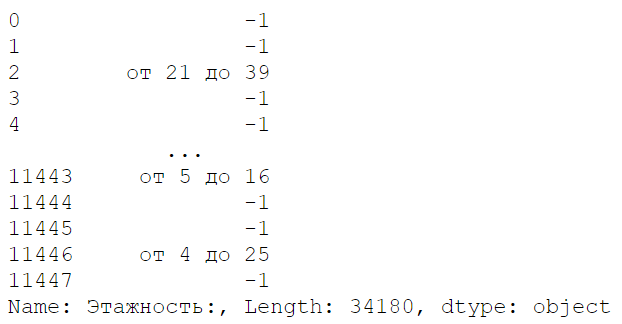

In [ ]:
max_Level=df["Этажность:"].str.split("до",expand=True)[1]
df["Этажность:"]=max_Level.fillna(-1)
df["Этажность:"]

In [ ]:
df["Этажность:"]=df["Этажность:"].replace(" ", "")

In [ ]:
f["Количество этажей:"]=np.where(df["Количество этажей:"] == -1, df["Этажность:"], df["Количество этажей:"])
df["Количество этажей:"]=df["Количество этажей:"].map(lambda x: int(x))
df["Количество этажей:"]=np.where(df["Количество этажей:"] == -1, df["Наибольшее количество этажей:"], df["Количество этажей:"])
df["Количество этажей:"]=df["Количество этажей:"].map(lambda x: int(x))
df["Количество этажей:"].value_counts(normalize=True)

In [ ]:
black_list=["Общая площадь:_cat","Этаж:_cat","Площадь кухни:_cat","Тип здания:_cat","Парковка:_cat",
            "Адрес:_cat","Охрана:_cat","Количество этажей:_cat","Этажность:_cat",
            "Наибольшее количество этажей:_cat"]
feats8_bl = ["Количество этажей:"]+[x for x in feats7_bl if x not in black_list]
check_model(df, feats8_bl, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

In [ ]:
feats8=["Количество этажей:"]+feats7
check_model(df, feats8, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

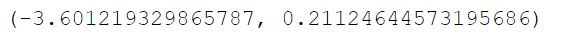

Заменила дублирующиеся занчения в типе объекта (квартиры, квартира). Вытянула из жилой комнаты числа по анологии с площадью ранее. Поэксперементировала с параметрами XGBoost max_depth=7, n_estimator=500 (1000). Модель улучшилась, но дальнейшие эксперементы с данными я проводила при прежних параметрах XGBoost для экономии времени и вернула их уже в конце

In [ ]:
df["Тип объекта:"]=df["Тип объекта:"].replace("квартиры","квартира")
df["Тип объекта:_cat"]=df["Тип объекта:"].factorize()[0]

In [ ]:
df["Жилая комната:_cat"]=df["Жилая комната:"].map(parse_area)

In [ ]:
black_list=["Общая площадь:_cat","Этаж:_cat","Площадь кухни:_cat","Тип здания:_cat","Парковка:_cat",
            "Адрес:_cat","Охрана:_cat","Количество этажей:_cat","Этажность:_cat",
            "Наибольшее количество этажей:_cat"]
feats8_bl = ["Количество этажей:"]+[x for x in feats7_bl if x not in black_list]
check_model(df, feats8_bl, xgb.XGBRegressor(max_depth=7, n_estimators=500, learning_rate=0.3, random_state=0))

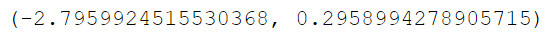

In [ ]:
black_list=["Общая площадь:_cat","Этаж:_cat","Площадь кухни:_cat","Тип здания:_cat","Парковка:_cat",
            "Адрес:_cat","Охрана:_cat","Количество этажей:_cat","Этажность:_cat",
            "Наибольшее количество этажей:_cat"]
feats8_bl = ["Количество этажей:"]+[x for x in feats7_bl if x not in black_list]
check_model(df, feats8_bl, xgb.XGBRegressor(max_depth=7, n_estimators=1000, learning_rate=0.1, random_state=0))

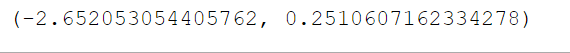

добавила логарифмирование площадей и в дальнейшем переключилась на проверку с лоiарифмированной ценой check_log_model. Модель улучшилась с 3.6 до 3.21, но выросло отклонение.

In [ ]:
area=df["area"]
df["log_area"]=np.log(area)
df["log_area"]=df["log_area"].fillna(-1)

kitchen=df["kitchen_area"]
df["log_kitchen"]=np.log(area)
df["log_kitchen"]=df["log_kitchen"].fillna(-1)

room = df["Жилая комната:"].map(parse_area)
df["log_room"] = np.log(room)
df["log_room"]=df["log_room"].fillna(-1)

In [ ]:
feats2=["log_area", "log_kitchen"]+["Level", "kitchen_area", "City", "Adress", "Parking", "Building_type", "Security", 
        "Количество этажей:"]+["area"] + cat_feats
check_log_model(df, feats2, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

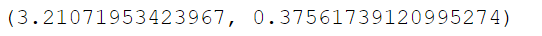

Адрес из breadcrumbs еще немного улучшил ситуацию  и сработало в этот раз исключение некоторых дублирующихся категорий (какие работают успешно подбералось методом проб и ошибок). При этом исключение площади кухни только с общей площадью ситуацию ухудшало, но вместе с этажом наооборот улучшало и так далее

In [ ]:
df["Adress2"] = df["breadcrumbs"].map(lambda x: x[-1])
df["Adress2"]=df["Adress2"].fillna(-1)
df["Adress2"] = df["Adress2"].factorize()[0]


In [ ]:
#With additional address taken from breadcrumbs
feats3=["Adress2"]+feats2
check_log_model(df, feats3, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

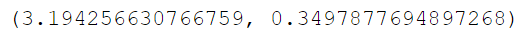

In [ ]:
black_list=["Общая площадь:_cat","Этаж:_cat","Площадь кухни:_cat","Тип здания:_cat","Парковка:_cat",
            "Адрес:_cat","Охрана:_cat","Количество этажей:_cat","Этажность:_cat",
            "Наибольшее количество этажей:_cat"]
feats3_bl = [x for x in feats3 if x not in black_list]
check_log_model(df, feats3_bl, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

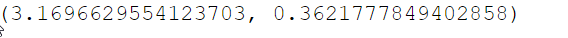

Приведение записи серии к одной логике ( в основном касательно записи индивидуального проэкта). Модель незначительно ухудшилась,но я оставила из-за логики стандартизации записи данных.

In [ ]:
#Standardize Series data
df["Серия:"]=df["Серия:"].replace(["Индивидуальный проект","Индивидуальный","Инд","индивидуальный проект",
                                  "индивидуальный","инд.", "индивид.", 
                                    "Индивидуальный проект с подземным паркингом", "серии нет, тип проекта - индивидуальный",
                                  "Индивид.", "индивидуал", "Индивидуальная", "Индив.", "Инд.","индив."],"индивид")
df["Серия:"]=df["Серия:"].replace(".","")
df["Серия:"]=df["Серия:"].replace(" ","")

df["Серия:_cat"]=df["Серия:"].factorize()[0]


In [ ]:
#With series clened
feats4=feats3
check_log_model(df, feats4, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

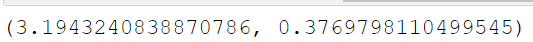

In [ ]:
black_list=["Общая площадь:_cat","Этаж:_cat","Площадь кухни:_cat","Тип здания:_cat","Парковка:_cat",
            "Адрес:_cat","Охрана:_cat","Количество этажей:_cat","Этажность:_cat",
            "Наибольшее количество этажей:_cat"]
feats4_bl = [x for x in feats4 if x not in black_list]
check_log_model(df, feats4_bl, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

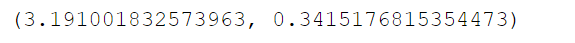

Вытягиваю данные из `geo_block` и `breadcrumbs`. Модель улучшилась до 3.1

In [ ]:
geo_block = (
df["geo_block"]
    .map(lambda x: x[:int(len(x)/2) ])
    .map(lambda x: {"geo_block_{}".format(idx):val for idx,val in enumerate(x) })
    .apply(pd.Series)
)

geo_block

In [ ]:
geo_cat_feats = [x for x in df.columns if "geo_block" in x and "_cat" in x]
geo_cat_feats

In [ ]:
breadcrumbs = (
    df["breadcrumbs"]
        .map(lambda x: {"breadcrumbs_{}".format(idx):val for idx,val in enumerate(x) })
        .apply(pd.Series)
)

breadcrumbs_cat_feats = [x for x in df.columns if "breadcrumbs" in x and "_cat" in x]
breadcrumbs_cat_feats

In [ ]:
feats1 = ["Level", "City", "Adress", "Parking", "Building_type", "Security", "Количество этажей:", 
         "Высота потолков:", "log_area", "log_kitchen", "log_room"] + ["area", "kitchen_area"] + geo_cat_feats + cat_feats + breadcrumbs_cat_feats

check_log_model(df, feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

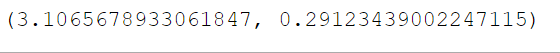

Идеи заканчивались, начала придумывать парметры, не все успешно, но некоторые улучшения наблюдались

In [ ]:
df["kitchen_ratio"]=np.where((df["kitchen_area"]!=-1) & (df["area"]!=-1),df["kitchen_area"]/df["area"],-1)


In [ ]:
df["Год постройки:"]=pd.to_numeric(df["Год постройки:"])
df["age"]=np.where(df["Год постройки:"]!=-1,(df["Год постройки:"] -[2021])*-1,-1)
df["age"]
#does not help

In [ ]:
feats2 = ["kitchen_ratio"]+feats1

check_log_model(df, feats2, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

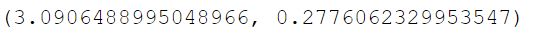

In [ ]:
home_features = ["Лифт:_cat", "Мусоропровод:_cat", "Мебель на кухне:_cat", "Холодильник:_cat",
    "Интернет:_cat", "Мебель:_cat", "Телефон:_cat", "Свободная планировка:_cat", "Телевизор:_cat", "Детская площадка:_cat",
    "Стиральная машина:_cat"]
df["home_features"] = df[home_features].sum(axis=1)
df["home_features"]
#not working

In [ ]:
feats3 = ["home_features"]+feats2

check_log_model(df, feats3, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

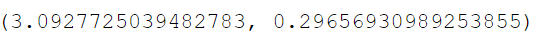

In [ ]:
df["offers_count"]=(
    df.groupby("Застройщик:")
    ["Застройщик:"]
    .transform("count")
)

df["offers_count"].value_counts()

In [ ]:
feats3 = ["offers_count"]+feats2

check_log_model(df, feats3, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

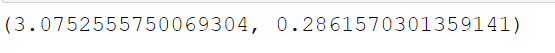

In [ ]:
df["area_per_Class"]=(
    df.groupby("Класс жилья:")
    ["area"]
    .transform("mean")
)

df["area_per_Class"].value_counts()

In [ ]:
feats4 = ["area_per_Class"]+feats3

check_log_model(df, feats4, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

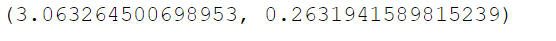

In [ ]:
df["area_per_company"]=(
    df.groupby("Застройщик:")
    ["area"]
    .transform("median")
)

df["area_per_company"].value_counts()


In [ ]:
feats5 = ["area_per_company"]+feats4

check_log_model(df, feats5, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

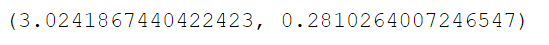

In [ ]:
df["area_per_company2"]=(
    df.groupby("Управляющая компания:")
    ["area"]
    .transform("mean")
)

df["area_per_company2"].value_counts()
#not working

Вернулась к подбору параметров на исключение с учетом всех новых

In [ ]:
black_list=["area","kitchen_area","Площадь кухни:_cat","Наибольшее количество этажей:_cat"]
feats5_bl = [x for x in feats5 if x not in black_list]
check_log_model(df, feats5_bl, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0))

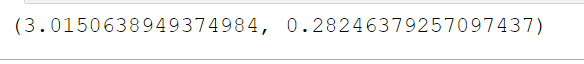

Поменяла параметры XGBoost max_depth=7, n_estimator=500, learning_rate=0.2

In [ ]:

check_log_model(df, feats5_bl, xgb.XGBRegressor(max_depth=7, n_estimators=500, learning_rate=0.2, random_state=0))

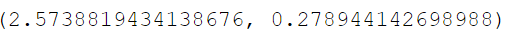

In [ ]:
feats = feats5_bl

df_train = df[ ~df["price"].isnull() ].copy()
df_test = df[ df["price"].isnull() ].copy()

X_train = df_train[feats]
y_train = df_train["price"]
y_log_train = np.log(y_train)

X_test = df_test[feats]

model = xgb.XGBRegressor(max_depth=7, n_estimators=500, learning_rate=0.2, random_state=0)
model.fit(X_train, y_log_train)
y_log_pred = model.predict(X_test)
y_pred = np.exp(y_log_pred)


df_test["price"] = y_pred
df_test[ ["id", "price"] ].to_csv("../output/xgb_location_log_area3.csv", index=False)

In [ ]:
black_list=["area","kitchen_area","Площадь кухни:_cat","Наибольшее количество этажей:_cat","City","Adress"]
feats6_bl = [x for x in feats5 if x not in black_list]
check_log_model(df, feats6_bl, xgb.XGBRegressor(max_depth=7, n_estimators=1000, learning_rate=0.2, random_state=0))

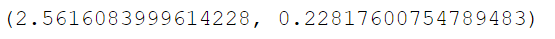

На Kaggle выгрузила уже предыдущий вариант так как разница мне показалась не большой, а идей на эксперементы больше не осталось